# Siamese CNN for Acoustic Word Embeddings

Herman Kamper, Stellenbosch University, 2019.

## Preliminaries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))
sys.path.append(path.join("..", "embeddings"))

import batching
import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Data

In [307]:
# Training data

# # NumPy archive (UTD)
# npz = np.load(
#     path.join("..", "features", "mfcc", "buckeye", "devpart1.utd.dd.npz")
#     )

# # NumPy archive (ground truth)
# npz = np.load(
#     path.join("..", "features", "mfcc", "buckeye", "devpart1.samediff.dd.npz")
#     )

# NumPy archive (larger ground truth)
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye", "devpart1.samediff2.dd.npz")
    )

# Data and labels
i_type = 0
word_to_id = {}
train_x = []
train_y = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    train_labels.append(word)
    if word not in word_to_id:
        word_to_id[word] = i_type
        i_type += 1
    train_y.append(word_to_id[word])
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 11979
E.g. item shape: (51, 39)


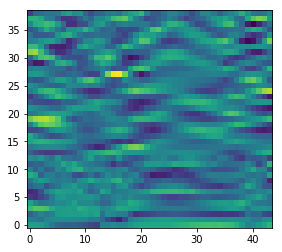

In [308]:
plt.imshow(train_x[3277].T, origin="bottom");

In [309]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye",
    "devpart2.samediff.dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_y = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    val_labels.append(word)
    if word not in word_to_id:
        word_to_id[word] = i_type
        i_type += 1
    val_y.append(word_to_id[word])
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)
print("No. word types in train and val:", len(word_to_id))

No. items: 2732
E.g. item shape: (61, 39)
No. word types in train and val: 4637


In [310]:
# Truncate and limit dimensionality
max_length = 101
d_frame = 39  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

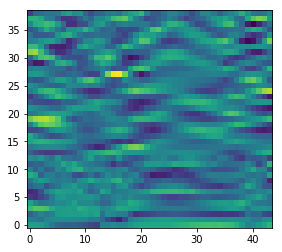

In [311]:
plt.imshow(train_x[3277].T, origin="bottom");

In [312]:
def pad_sequences(x, n_padded, center_padded=True):
    """Return the padded sequences and their original lengths."""
    padded_x = np.zeros((len(x), n_padded, x[0].shape[1]), dtype=NP_DTYPE)
    lengths = []
    for i_data, cur_x in enumerate(x):
        length = cur_x.shape[0]
        if center_padded:
            padding = int(np.round((n_padded - length) / 2.))
            if length <= n_padded:
                padded_x[i_data, padding:padding + length, :] = cur_x
            else:
                # Cut out snippet from sequence exceeding n_padded
                padded_x[i_data, :, :] = cur_x[-padding:-padding + n_padded]
            lengths.append(min(length, n_padded))
        else:
            length = min(length, n_padded)
            padded_x[i_data, :length, :] = cur_x[:length, :]
            lengths.append(length)
    return padded_x, lengths

In [313]:
# Zero-pad
train_x, _ = pad_sequences(train_x, max_length, True)  # tune
val_x, _ = pad_sequences(val_x, max_length, True)  # tune
train_x = np.transpose(train_x, (0, 2, 1))
val_x = np.transpose(val_x, (0, 2, 1))

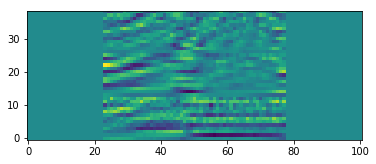

In [314]:
plt.imshow(train_x[3227], origin="bottom");

## Multi-layer CNN-Siamese with semi-hard triplets loss

In [315]:
def build_siamese_cnn_side(x, input_shape, filter_shapes, pool_shapes,
        ff_n_hiddens, ff_keep_prob=1.0):
    """
    CNN serving as one side of a Siamese model.
    
    See `tflego.build_cnn` for more details on the parameters.

    Parameters
    ----------
    x : Tensor [n_data, n_input]
        Input to the CNN, which is reshaped to match `input_shape`.
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    """
    cnn = tflego.build_cnn(x, input_shape, filter_shapes, pool_shapes, padding="VALID")
    cnn = tf.contrib.layers.flatten(cnn)
    cnn = tflego.build_feedforward(cnn, ff_n_hiddens, keep_prob=ff_keep_prob)
    return cnn

In [316]:
tf.reset_default_graph()

# Data
d_in = train_x.shape[1]*train_x.shape[2]
train_x_array = train_x.reshape((-1, d_in))
train_y_array = np.array(train_y)
val_x_array = val_x.reshape((-1, d_in))

# Training parameters
learning_rate = 0.001
n_epochs = 150
n_val_interval = 5
batch_size = 600
# ff_keep_prob = 1.0
train_matches_vec = samediff.generate_matches_array(train_labels)

# Model parameters
input_shape = [-1, train_x.shape[1], train_x.shape[2], 1]  # [n_data, height, width, channels]
filter_shapes = [
    [39, 8, 1, 64],
    [1, 6, 64, 256],
    [1, 5, 256, 1024]
    ]
pool_shapes = [
    [1, 2],
    [1, 2],
    [1, 17]
    ]
# filter_shapes = [
#     [39, 9, 1, 64],
#     [1, 8, 64, 1024]
#     ]
# pool_shapes = [
#     [1, 3],
#     [1, 24]
#     ]
ff_n_hiddens = [1024, 130]  # the last hidden layer is linear
margin = 0.25
intermediate_model_fn = path.join(output_dir, "cnn_siamese_triplets.tmp.ckpt")
model_fn = path.join(output_dir, "cnn_siamese_triplets.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, d_in])
y = tf.placeholder(TF_ITYPE, [None])
cnn = build_siamese_cnn_side(
    x, input_shape, filter_shapes, pool_shapes, ff_n_hiddens
    )
cnn = tf.nn.l2_normalize(cnn, axis=1)

# Contrastive loss
loss = tf.contrib.losses.metric_learning.triplet_semihard_loss(
    labels=y, embeddings=cnn, margin=margin
    )
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

CNN layer 0 shape: [None, 1, 47, 64]
CNN layer 1 shape: [None, 1, 21, 256]
CNN layer 2 shape: [None, 1, 1, 1024]


In [317]:
class Iterator(object):
    """
    Iterator without bucketing or padding but with labels.
    
    If `y_vec` is set to None, no labels are yielded.
    """
    
    def __init__(self, x_mat, y_vec, batch_size, shuffle_every_epoch=False):
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_batches = int(np.floor(x_mat.shape[0]/batch_size))
        self.indices = np.arange(x_mat.shape[0])
        self.shuffle()
    
    def shuffle(self):
        np.random.shuffle(self.indices)
    
    def __iter__(self):
        if self.shuffle_every_epoch:
            self.shuffle()
        for i_batch in range(self.n_batches):
            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            if self.y_vec is None:
                yield (self.x_mat[batch_indices])
            else:
                yield (self.x_mat[batch_indices], self.y_vec[batch_indices])


In [318]:
def samediff_val(normalise=True):
    # Embed validation
    np.random.seed(1)
    val_batch_iterator = Iterator(
        val_x_array, y_vec=None, batch_size=val_x.shape[0], shuffle_every_epoch=False
        )
    labels = [val_labels[i] for i in val_batch_iterator.indices]
    saver = tf.train.Saver()
    with tf.Session() as session:
        saver.restore(session, val_model_fn)
        for batch_x in val_batch_iterator:
            np_z = session.run(
                [cnn], feed_dict={x: batch_x}
                )[0]
            break  # single batch

    embed_dict = {}
    for i, utt_key in enumerate(
            [val_keys[i] for i in val_batch_iterator.indices]):
        embed_dict[utt_key] = np_z[i]

    # Same-different
    if normalise:
        np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
        distances = pdist(np_z_normalised, metric="cosine")
        matches = samediff.generate_matches_array(labels)
        ap, prb = samediff.average_precision(
            distances[matches == True], distances[matches == False]
            )
    else:
        distances = pdist(np_z, metric="cosine")
        matches = samediff.generate_matches_array(labels)
        ap, prb = samediff.average_precision(
            distances[matches == True], distances[matches == False]
            )    
    return [prb, -ap]

In [319]:
# Train CNN-Siamese

np.random.seed(1)

train_batch_iterator = Iterator(
    train_x_array, train_y_array, batch_size, shuffle_every_epoch=True
    )

val_model_fn = intermediate_model_fn

record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [x, y], samediff_val,
    save_model_fn=intermediate_model_fn,
    save_best_val_model_fn=model_fn,
    n_val_interval=n_val_interval
    )

2019-06-06 09:59:05.860521
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cnn_siamese_triplets.tmp.ckpt
5.460 sec, train loss: 0.24987635, val loss: [0.20340733092410945, -0.13524089534290387] *
Epoch 1:
2.659 sec, train loss: 0.24838518
Epoch 2:
2.644 sec, train loss: 0.24616703
Epoch 3:
2.644 sec, train loss: 0.23249589
Epoch 4:
2.642 sec, train loss: 0.16928874
Epoch 5:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cnn_siamese_triplets.tmp.ckpt
5.219 sec, train loss: 0.13567474, val loss: [0.3425400103252452, -0.3001982061134649] *
Epoch 6:
2.645 sec, train loss: 0.1063055
Epoch 7:
2.639 sec, train loss: 0.086103
Epoch 8:
2.639 sec, train loss: 0.07473675
Epoch 9:
2.638 sec, train loss: 0.06152902
Epoch 10:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cnn_siamese_triplets.tmp.ckpt
5.242 sec, train loss: 0.054260723, val loss: [0.4966451610668994, -0.4897475864950607] *
Epoch 11:
2.646 sec, train loss: 0.048138358
Epoch 12:
2.648 sec

KeyboardInterrupt: 